In [18]:
import torch.hub
import torchvision
import numpy as np
from PIL import Image, ImageOps
import os
import time
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
# Download models
repo = 'epic-kitchens/action-models'

class_counts = (125, 352)
segment_count = 8
base_model = 'resnet50'

tsn = torch.hub.load(repo, 'TSN', class_counts, segment_count, 'RGB',
                     base_model=base_model, 
                     pretrained='epic-kitchens', force_reload=True)
trn = torch.hub.load(repo, 'TRN', class_counts, segment_count, 'RGB',
                     base_model=base_model, 
                     pretrained='epic-kitchens')
mtrn = torch.hub.load(repo, 'MTRN', class_counts, segment_count, 'RGB',
                     base_model=base_model, 
                      pretrained='epic-kitchens')
tsm = torch.hub.load(repo, 'TSM', class_counts, segment_count, 'RGB',
                     base_model=base_model, 
                     pretrained='epic-kitchens')

Downloading: "https://github.com/epic-kitchens/action-models/archive/master.zip" to /home/dimitri/.cache/torch/hub/master.zip
Using cache found in /home/dimitri/.cache/torch/hub/epic-kitchens_action-models_master
Using cache found in /home/dimitri/.cache/torch/hub/epic-kitchens_action-models_master


Multi-Scale Temporal Relation Network Module in use ['8-frame relation', '7-frame relation', '6-frame relation', '5-frame relation', '4-frame relation', '3-frame relation', '2-frame relation']


Using cache found in /home/dimitri/.cache/torch/hub/epic-kitchens_action-models_master


In [20]:
# Transforms
class GroupScale(object):
    """ Rescales the input PIL.Image to the given 'size'.
    'size' will be the size of the smaller edge.
    For example, if height > width, then image will be
    rescaled to (size * height / width, size)
    size: size of the smaller edge
    interpolation: Default: PIL.Image.BILINEAR
    """

    def __init__(self, size, interpolation=Image.BILINEAR):
        self.worker = torchvision.transforms.Scale(size, interpolation)

    def __call__(self, img_group):
        return [self.worker(img) for img in img_group]
       

class GroupCenterCrop(object):
    def __init__(self, size):
        self.worker = torchvision.transforms.CenterCrop(size)

    def __call__(self, img_group):
        return [self.worker(img) for img in img_group]
    

class Stack(object):    
    def __call__(self, img_group):
        return np.array([np.array(i) for i in img_group])
    

class ToTorchFormatTensor(object):    
    def __call__(self, pic):
        img = torch.from_numpy(pic).permute(0, 3, 1, 2).contiguous()
        return img.float().div(255) 
    

class GroupNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        rep_mean = self.mean * (tensor.size()[0]//len(self.mean))
        rep_std = self.std * (tensor.size()[0]//len(self.std))

        # TODO: make efficient
        for t, m, s in zip(tensor, rep_mean, rep_std):
            t.sub_(m).div_(s)

        return tensor

We downloaded a video from youtube https://www.youtube.com/watch?v=pm73PXfodts&t=132s. 
We made manual annotations on it. Each line is an annotated interval of a video.

In [21]:
# start_time,end_time,verb,noun
# 1.19,1.25,put,chicken
# 1.26,1.36,mix,chicken
# 1.43,1.52,pour,can
# 2.00,2.29,add,flour
# 2.30,2.38,mix,flour
# 3.22,3.52,cook,flour
# 3.54,4.17,put,chicken
# 4.19,4.28,mix,liquid
# 4.40,4.51,cook,liquid
# 4.57,5.46,take,chicken
# 5.48,6.00,put,chicken

I got EPIC Kitchen 55 dataset target annotations from the web. The following script combines these data into one dataframe.

In [22]:
noun_classes_data = pd.read_csv("data/EPIC_noun_classes.csv")
verb_classes_data = pd.read_csv("data/EPIC_verb_classes.csv")

annotations_data = pd.read_csv("data/kfc3.csv")
annotations = pd.merge(annotations_data, verb_classes_data, left_on='verb', right_on='class_key')
annotations = pd.merge(annotations, noun_classes_data, left_on='noun', right_on='class_key')
annotations = annotations[["start_time", "end_time", "verb", "noun", "verb_id", "noun_id"]]
annotations = annotations.sort_values("start_time")
annotations["start_frame"] = ((annotations["start_time"] // 1) * 60 + (annotations["start_time"] % 1) * 100) * 30
annotations["end_frame"] = ((annotations["end_time"] // 1) * 60 + (annotations["end_time"] % 1) * 100) * 30
annotations

,start_time,end_time,verb,noun,verb_id,noun_id,start_frame,end_frame
0,1.19,1.25,put,chicken,1,62,2370.0,2550.0
3,1.26,1.36,mix,chicken,6,62,2580.0,2880.0
10,1.43,1.52,pour,can,7,87,3090.0,3360.0
6,2.00,2.29,add,flour,25,93,3600.0,4470.0
5,2.30,2.38,mix,flour,6,93,4500.0,4740.0
7,3.22,3.52,cook,flour,47,93,6060.0,6960.0
1,3.54,4.17,put,chicken,1,62,7020.0,7710.0
8,4.19,4.28,mix,liquid,6,71,7770.0,8040.0
9,4.40,4.51,cook,liquid,47,71,8400.0,8730.0
4,4.57,5.46,take,chicken,0,62,8910.0,10380.0


We define dataset class, to help us run the models. It returns stacked up frames from the video together with labels. 

data_dir is the directory in which the video frames are located.

The video is divided into equal sized segments. To form a stack we select one frame a segment from a few consecutive segments. For this we have two parameters: segment_num is the number of consecutive segments we select frames from, and segment_size is the size of each segment. At index i our dataset returns stacked up frames starting at frame i.

Thus, each input represents a (segment_num x segment_size) long part of a video. We assign a label to this part of the video using our annotations above. A label is assigned only if the part of the video intersects by 75% with one of the annotated intervals.

In [23]:
class EpicKitchenDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, annotations, transform, segment_num, segment_size):
        self.data_dir = data_dir
        self.annotations = annotations
        self.transform = transform
        
        self.segment_num = segment_num
        self.segment_size = segment_size
        
        self.action_margin = int(0.75 * self.segment_size * self.segment_num)
    
    def __getitem__(self, index):
        image_paths = [os.path.join(self.data_dir, "{}.jpg".format(str(index + i * self.segment_size).zfill(5)))
                       for i in range(self.segment_num)]
        images = [Image.open(image_p).convert('RGB') for image_p in image_paths]
        
        df = annotations[(annotations["start_frame"] - self.action_margin < index) 
                         & (annotations["end_frame"] - self.action_margin > index)]
        if not df.empty:
            label = (df["verb_id"].iloc[0], df["noun_id"].iloc[0])
        else:
            label = None
        
        
        return self.transform(images), label

We define a function to run models. The results are accumulated in the results parameters. 

In [24]:
# results[0] - frame numbers
# results[1] - processing time
# results[2] - predicted verb id
# results[3] - target verb id
# results[4] - predicted noun id
# results[5] - target noun id
# results[6] - verb loss
# results[7] - noun loss

In [25]:
def run_model(net, dir_name, results, step=30, on_gpu=True):
    dir_name = os.path.join("data", dir_name)
    transform=torchvision.transforms.Compose([
                       GroupScale(int(net.scale_size)),
                       GroupCenterCrop(net.input_size),
                       Stack(),
                       ToTorchFormatTensor(),
                       GroupNormalize(net.input_mean, net.input_std),
                   ])
    
    frames_n = len(os.listdir(dir_name))
    segment_num = 8
    segment_size = 30
    
    loss = torch.nn.CrossEntropyLoss()
    
    dataset = EpicKitchenDataset(dir_name, annotations, transform, segment_num, segment_size)
    if on_gpu:
        net.cuda()
    
    fps = 30
    with torch.no_grad():
        for k in range(1, frames_n - segment_num * int(segment_size), step):
            inputs, label = dataset[k]
            if label is None:
                verb_target, noun_target = None, None
            else:
                verb_target, noun_target = label[0], label[1]
            if on_gpu:
                inputs = inputs.cuda()
            start_time = time.time()
            features = net.features(inputs)
            verb_logits, noun_logits = net.logits(features)
            duration = time.time() - start_time 
            verb_pred = torch.argmax(verb_logits).item()
            noun_pred = torch.argmax(noun_logits).item() 
            if label is not None:
                verb_loss = loss(verb_logits, torch.tensor([verb_target], dtype=torch.long).cuda()).item()
                noun_loss = loss(noun_logits, torch.tensor([noun_target], dtype=torch.long).cuda()).item()
            else:
                verb_loss = None
                noun_loss = None
            
            results[0].append(k)
            results[1].append(duration)
            results[2].append(verb_pred)
            results[3].append(verb_target)
            results[4].append(noun_pred)
            results[5].append(noun_target)
            results[6].append(verb_loss)
            results[7].append(noun_loss)
            
            if label:
                print("time: {}.{}, verb: {}/{}, noun: {}/{}, duration: {:1.4f}, verb_loss: {:1.4f}, noun_loss: {:1.4f}".format(
                    int(k / fps) // 60,
                    int(k / fps) % 60, 
                    verb_pred,
                    verb_target,
                    noun_pred,
                    noun_target,
                    duration,
                    verb_loss,
                    noun_loss))
            else:
                print("time: {}.{}, verb: {}/, noun: {}/, duration: {:1.4f}".format(
                    int(k / fps) // 60,
                    int(k / fps) % 60, 
                    verb_pred,
                    noun_pred,
                    duration))

We ran tsn and tsm models on the video. Since the models were trained for videos similar to our one, models do not perform well. They output random predictions. 

In [26]:
results_tsn = [list(), list(), list(), list(), list(), list(), list(), list()]
run_model(tsn, "kfc3_frames", results_tsn)

/home/dimitri/.conda/envs/epic/lib/python3.7/site-packages/torchvision/transforms/transforms.py:256: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


time: 0.0, verb: 0/, noun: 1/, duration: 0.0100
time: 0.1, verb: 1/, noun: 1/, duration: 0.0120
time: 0.2, verb: 1/, noun: 1/, duration: 0.0093
time: 0.3, verb: 1/, noun: 1/, duration: 0.0118
time: 0.4, verb: 1/, noun: 1/, duration: 0.0115
time: 0.5, verb: 1/, noun: 1/, duration: 0.0098
time: 0.6, verb: 1/, noun: 1/, duration: 0.0094
time: 0.7, verb: 0/, noun: 1/, duration: 0.0102
time: 0.8, verb: 1/, noun: 1/, duration: 0.0106
time: 0.9, verb: 1/, noun: 1/, duration: 0.0106
time: 0.10, verb: 1/, noun: 1/, duration: 0.0092
time: 0.11, verb: 1/, noun: 1/, duration: 0.0139
time: 0.12, verb: 1/, noun: 6/, duration: 0.0109
time: 0.13, verb: 1/, noun: 1/, duration: 0.0105
time: 0.14, verb: 1/, noun: 7/, duration: 0.0104
time: 0.15, verb: 1/, noun: 4/, duration: 0.0092
time: 0.16, verb: 1/, noun: 7/, duration: 0.0107
time: 0.17, verb: 1/, noun: 1/, duration: 0.0097
time: 0.18, verb: 1/, noun: 1/, duration: 0.0106
time: 0.19, verb: 1/, noun: 7/, duration: 0.0093
time: 0.20, verb: 1/, noun: 5/

time: 2.12, verb: 1/25, noun: 4/93, duration: 0.0099, verb_loss: 10.7913, noun_loss: 9.0335
time: 2.13, verb: 0/25, noun: 1/93, duration: 0.0093, verb_loss: 10.9916, noun_loss: 9.6891
time: 2.14, verb: 1/25, noun: 1/93, duration: 0.0095, verb_loss: 11.1601, noun_loss: 8.4443
time: 2.15, verb: 1/25, noun: 1/93, duration: 0.0099, verb_loss: 10.7911, noun_loss: 8.9530
time: 2.16, verb: 1/25, noun: 1/93, duration: 0.0091, verb_loss: 10.7720, noun_loss: 8.5600
time: 2.17, verb: 1/25, noun: 1/93, duration: 0.0103, verb_loss: 11.0017, noun_loss: 8.8589
time: 2.18, verb: 0/25, noun: 1/93, duration: 0.0095, verb_loss: 11.5059, noun_loss: 8.7159
time: 2.19, verb: 1/25, noun: 4/93, duration: 0.0102, verb_loss: 11.2713, noun_loss: 8.9100
time: 2.20, verb: 1/25, noun: 1/93, duration: 0.0098, verb_loss: 10.5280, noun_loss: 8.8451
time: 2.21, verb: 0/25, noun: 11/93, duration: 0.0095, verb_loss: 11.3875, noun_loss: 8.8885
time: 2.22, verb: 1/25, noun: 4/93, duration: 0.0098, verb_loss: 11.3144, noun_

time: 4.4, verb: 1/1, noun: 1/62, duration: 0.0096, verb_loss: 0.6308, noun_loss: 7.2381
time: 4.5, verb: 1/1, noun: 1/62, duration: 0.0111, verb_loss: 0.6429, noun_loss: 7.5735
time: 4.6, verb: 1/1, noun: 1/62, duration: 0.0091, verb_loss: 0.6851, noun_loss: 6.5566
time: 4.7, verb: 1/1, noun: 1/62, duration: 0.0094, verb_loss: 0.6544, noun_loss: 7.0688
time: 4.8, verb: 1/1, noun: 1/62, duration: 0.0092, verb_loss: 0.4921, noun_loss: 6.7877
time: 4.9, verb: 1/1, noun: 1/62, duration: 0.0094, verb_loss: 0.6276, noun_loss: 6.5634
time: 4.10, verb: 1/1, noun: 1/62, duration: 0.0095, verb_loss: 0.6750, noun_loss: 6.6581
time: 4.11, verb: 1/, noun: 1/, duration: 0.0092
time: 4.12, verb: 1/, noun: 1/, duration: 0.0095
time: 4.13, verb: 1/6, noun: 1/71, duration: 0.0096, verb_loss: 8.4021, noun_loss: 7.7440
time: 4.14, verb: 1/6, noun: 1/71, duration: 0.0100, verb_loss: 9.0518, noun_loss: 7.5502
time: 4.15, verb: 1/6, noun: 7/71, duration: 0.0092, verb_loss: 8.5196, noun_loss: 7.4598
time: 4.

time: 5.46, verb: 1/1, noun: 4/62, duration: 0.0095, verb_loss: 0.5861, noun_loss: 7.2578
time: 5.47, verb: 1/1, noun: 1/62, duration: 0.0095, verb_loss: 0.5586, noun_loss: 7.0910
time: 5.48, verb: 1/1, noun: 1/62, duration: 0.0092, verb_loss: 0.6583, noun_loss: 7.1644
time: 5.49, verb: 1/1, noun: 11/62, duration: 0.0095, verb_loss: 0.5958, noun_loss: 7.1275
time: 5.50, verb: 1/1, noun: 1/62, duration: 0.0096, verb_loss: 0.6622, noun_loss: 6.3155
time: 5.51, verb: 1/1, noun: 1/62, duration: 0.0094, verb_loss: 0.5630, noun_loss: 7.1008
time: 5.52, verb: 1/1, noun: 4/62, duration: 0.0095, verb_loss: 0.5618, noun_loss: 6.8088
time: 5.53, verb: 1/1, noun: 1/62, duration: 0.0092, verb_loss: 0.6305, noun_loss: 6.5161
time: 5.54, verb: 1/, noun: 1/, duration: 0.0095
time: 5.55, verb: 1/, noun: 1/, duration: 0.0099
time: 5.56, verb: 1/, noun: 5/, duration: 0.0094
time: 5.57, verb: 0/, noun: 1/, duration: 0.0094
time: 5.58, verb: 1/, noun: 1/, duration: 0.0101
time: 5.59, verb: 1/, noun: 11/, d

time: 8.28, verb: 1/, noun: 1/, duration: 0.0104
time: 8.29, verb: 1/, noun: 6/, duration: 0.0092
time: 8.30, verb: 1/, noun: 1/, duration: 0.0096
time: 8.31, verb: 1/, noun: 1/, duration: 0.0095
time: 8.32, verb: 1/, noun: 1/, duration: 0.0100
time: 8.33, verb: 1/, noun: 1/, duration: 0.0095
time: 8.34, verb: 1/, noun: 1/, duration: 0.0102
time: 8.35, verb: 1/, noun: 1/, duration: 0.0093
time: 8.36, verb: 1/, noun: 1/, duration: 0.0103
time: 8.37, verb: 1/, noun: 1/, duration: 0.0094
time: 8.38, verb: 0/, noun: 1/, duration: 0.0103
time: 8.39, verb: 1/, noun: 1/, duration: 0.0095
time: 8.40, verb: 1/, noun: 5/, duration: 0.0099
time: 8.41, verb: 1/, noun: 1/, duration: 0.0100
time: 8.42, verb: 1/, noun: 5/, duration: 0.0098
time: 8.43, verb: 1/, noun: 1/, duration: 0.0093
time: 8.44, verb: 1/, noun: 5/, duration: 0.0107
time: 8.45, verb: 0/, noun: 4/, duration: 0.0093
time: 8.46, verb: 1/, noun: 6/, duration: 0.0103
time: 8.47, verb: 1/, noun: 4/, duration: 0.0095
time: 8.48, verb: 1/

time: 11.16, verb: 1/, noun: 7/, duration: 0.0099
time: 11.17, verb: 1/, noun: 1/, duration: 0.0097
time: 11.18, verb: 1/, noun: 11/, duration: 0.0104
time: 11.19, verb: 1/, noun: 1/, duration: 0.0099
time: 11.20, verb: 1/, noun: 7/, duration: 0.0104
time: 11.21, verb: 1/, noun: 4/, duration: 0.0094
time: 11.22, verb: 1/, noun: 4/, duration: 0.0094
time: 11.23, verb: 1/, noun: 11/, duration: 0.0093
time: 11.24, verb: 1/, noun: 1/, duration: 0.0102
time: 11.25, verb: 0/, noun: 4/, duration: 0.0098
time: 11.26, verb: 1/, noun: 1/, duration: 0.0095
time: 11.27, verb: 1/, noun: 1/, duration: 0.0095
time: 11.28, verb: 1/, noun: 1/, duration: 0.0110
time: 11.29, verb: 1/, noun: 1/, duration: 0.0094
time: 11.30, verb: 1/, noun: 1/, duration: 0.0106
time: 11.31, verb: 1/, noun: 4/, duration: 0.0099
time: 11.32, verb: 1/, noun: 4/, duration: 0.0099
time: 11.33, verb: 1/, noun: 4/, duration: 0.0094
time: 11.34, verb: 1/, noun: 7/, duration: 0.0109
time: 11.35, verb: 1/, noun: 1/, duration: 0.009

time: 14.2, verb: 1/, noun: 1/, duration: 0.0113
time: 14.3, verb: 1/, noun: 1/, duration: 0.0095
time: 14.4, verb: 1/, noun: 1/, duration: 0.0101
time: 14.5, verb: 1/, noun: 1/, duration: 0.0109
time: 14.6, verb: 1/, noun: 1/, duration: 0.0127
time: 14.7, verb: 1/, noun: 11/, duration: 0.0164
time: 14.8, verb: 1/, noun: 7/, duration: 0.0124
time: 14.9, verb: 1/, noun: 1/, duration: 0.0114
time: 14.10, verb: 0/, noun: 4/, duration: 0.0109
time: 14.11, verb: 1/, noun: 1/, duration: 0.0109
time: 14.12, verb: 1/, noun: 1/, duration: 0.0128
time: 14.13, verb: 1/, noun: 1/, duration: 0.0118
time: 14.14, verb: 1/, noun: 1/, duration: 0.0149
time: 14.15, verb: 1/, noun: 5/, duration: 0.0161
time: 14.16, verb: 1/, noun: 11/, duration: 0.0130
time: 14.17, verb: 1/, noun: 1/, duration: 0.0113
time: 14.18, verb: 1/, noun: 11/, duration: 0.0172
time: 14.19, verb: 1/, noun: 1/, duration: 0.0119
time: 14.20, verb: 1/, noun: 1/, duration: 0.0154
time: 14.21, verb: 1/, noun: 1/, duration: 0.0176
time:

In [27]:
results_tsm = [list(), list(), list(), list(), list(), list(), list(), list()]
run_model(tsm, "kfc3_frames", results_tsm)

/home/dimitri/.conda/envs/epic/lib/python3.7/site-packages/torchvision/transforms/transforms.py:256: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


time: 0.0, verb: 1/, noun: 4/, duration: 0.0118
time: 0.1, verb: 1/, noun: 1/, duration: 0.0129
time: 0.2, verb: 0/, noun: 1/, duration: 0.0133
time: 0.3, verb: 1/, noun: 1/, duration: 0.0144
time: 0.4, verb: 1/, noun: 11/, duration: 0.0132
time: 0.5, verb: 0/, noun: 5/, duration: 0.0141
time: 0.6, verb: 1/, noun: 7/, duration: 0.0139
time: 0.7, verb: 1/, noun: 7/, duration: 0.0124
time: 0.8, verb: 0/, noun: 7/, duration: 0.0156
time: 0.9, verb: 1/, noun: 1/, duration: 0.0127
time: 0.10, verb: 1/, noun: 1/, duration: 0.0162
time: 0.11, verb: 1/, noun: 1/, duration: 0.0169
time: 0.12, verb: 1/, noun: 4/, duration: 0.0130
time: 0.13, verb: 1/, noun: 7/, duration: 0.0130
time: 0.14, verb: 1/, noun: 1/, duration: 0.0154
time: 0.15, verb: 1/, noun: 1/, duration: 0.0144
time: 0.16, verb: 1/, noun: 4/, duration: 0.0154
time: 0.17, verb: 1/, noun: 1/, duration: 0.0124
time: 0.18, verb: 1/, noun: 1/, duration: 0.0125
time: 0.19, verb: 1/, noun: 1/, duration: 0.0145
time: 0.20, verb: 1/, noun: 1

time: 2.12, verb: 1/25, noun: 1/93, duration: 0.0148, verb_loss: 11.0823, noun_loss: 7.8734
time: 2.13, verb: 1/25, noun: 1/93, duration: 0.0125, verb_loss: 10.9205, noun_loss: 8.3251
time: 2.14, verb: 1/25, noun: 4/93, duration: 0.0136, verb_loss: 11.6098, noun_loss: 7.8613
time: 2.15, verb: 1/25, noun: 1/93, duration: 0.0120, verb_loss: 11.1370, noun_loss: 7.3158
time: 2.16, verb: 1/25, noun: 1/93, duration: 0.0130, verb_loss: 11.7528, noun_loss: 8.6494
time: 2.17, verb: 1/25, noun: 4/93, duration: 0.0137, verb_loss: 11.1325, noun_loss: 9.0735
time: 2.18, verb: 1/25, noun: 1/93, duration: 0.0131, verb_loss: 11.2883, noun_loss: 9.2066
time: 2.19, verb: 1/25, noun: 11/93, duration: 0.0138, verb_loss: 9.7156, noun_loss: 7.7575
time: 2.20, verb: 1/25, noun: 7/93, duration: 0.0123, verb_loss: 11.1725, noun_loss: 8.4417
time: 2.21, verb: 1/25, noun: 1/93, duration: 0.0142, verb_loss: 10.6031, noun_loss: 8.1428
time: 2.22, verb: 1/25, noun: 11/93, duration: 0.0130, verb_loss: 11.0000, noun_

time: 4.4, verb: 1/1, noun: 1/62, duration: 0.0170, verb_loss: 0.5677, noun_loss: 6.3153
time: 4.5, verb: 1/1, noun: 1/62, duration: 0.0130, verb_loss: 0.5040, noun_loss: 6.8218
time: 4.6, verb: 1/1, noun: 1/62, duration: 0.0133, verb_loss: 0.4564, noun_loss: 6.9491
time: 4.7, verb: 1/1, noun: 6/62, duration: 0.0132, verb_loss: 0.6417, noun_loss: 7.5478
time: 4.8, verb: 1/1, noun: 1/62, duration: 0.0123, verb_loss: 0.2945, noun_loss: 7.0202
time: 4.9, verb: 1/1, noun: 1/62, duration: 0.0128, verb_loss: 0.6142, noun_loss: 8.1668
time: 4.10, verb: 1/1, noun: 1/62, duration: 0.0124, verb_loss: 0.5573, noun_loss: 8.3401
time: 4.11, verb: 1/, noun: 11/, duration: 0.0139
time: 4.12, verb: 1/, noun: 1/, duration: 0.0192
time: 4.13, verb: 1/6, noun: 1/71, duration: 0.0150, verb_loss: 9.0673, noun_loss: 7.6898
time: 4.14, verb: 0/6, noun: 1/71, duration: 0.0170, verb_loss: 10.5753, noun_loss: 6.1370
time: 4.15, verb: 0/6, noun: 1/71, duration: 0.0149, verb_loss: 9.4463, noun_loss: 7.6513
time: 

time: 5.45, verb: 0/1, noun: 1/62, duration: 0.0207, verb_loss: 0.7821, noun_loss: 7.2346
time: 5.46, verb: 1/1, noun: 1/62, duration: 0.0176, verb_loss: 0.3851, noun_loss: 6.4727
time: 5.47, verb: 1/1, noun: 1/62, duration: 0.0181, verb_loss: 0.4413, noun_loss: 6.4360
time: 5.48, verb: 1/1, noun: 5/62, duration: 0.0155, verb_loss: 0.2588, noun_loss: 7.5990
time: 5.49, verb: 1/1, noun: 1/62, duration: 0.0160, verb_loss: 0.5985, noun_loss: 7.5937
time: 5.50, verb: 1/1, noun: 1/62, duration: 0.0164, verb_loss: 0.6941, noun_loss: 7.1813
time: 5.51, verb: 1/1, noun: 6/62, duration: 0.0153, verb_loss: 0.3190, noun_loss: 7.4621
time: 5.52, verb: 1/1, noun: 4/62, duration: 0.0149, verb_loss: 0.6330, noun_loss: 7.1077
time: 5.53, verb: 1/1, noun: 1/62, duration: 0.0152, verb_loss: 0.7298, noun_loss: 7.4644
time: 5.54, verb: 1/, noun: 1/, duration: 0.0208
time: 5.55, verb: 0/, noun: 4/, duration: 0.0149
time: 5.56, verb: 1/, noun: 1/, duration: 0.0177
time: 5.57, verb: 1/, noun: 1/, duration: 0

time: 8.26, verb: 1/, noun: 1/, duration: 0.0134
time: 8.27, verb: 0/, noun: 1/, duration: 0.0141
time: 8.28, verb: 1/, noun: 1/, duration: 0.0130
time: 8.29, verb: 1/, noun: 1/, duration: 0.0152
time: 8.30, verb: 1/, noun: 4/, duration: 0.0154
time: 8.31, verb: 1/, noun: 1/, duration: 0.0146
time: 8.32, verb: 1/, noun: 1/, duration: 0.0130
time: 8.33, verb: 1/, noun: 5/, duration: 0.0139
time: 8.34, verb: 0/, noun: 1/, duration: 0.0154
time: 8.35, verb: 1/, noun: 5/, duration: 0.0129
time: 8.36, verb: 1/, noun: 1/, duration: 0.0292
time: 8.37, verb: 1/, noun: 1/, duration: 0.0174
time: 8.38, verb: 1/, noun: 1/, duration: 0.0150
time: 8.39, verb: 1/, noun: 1/, duration: 0.0132
time: 8.40, verb: 1/, noun: 1/, duration: 0.0160
time: 8.41, verb: 1/, noun: 4/, duration: 0.0158
time: 8.42, verb: 1/, noun: 1/, duration: 0.0151
time: 8.43, verb: 1/, noun: 1/, duration: 0.0129
time: 8.44, verb: 1/, noun: 1/, duration: 0.0137
time: 8.45, verb: 1/, noun: 1/, duration: 0.0192
time: 8.46, verb: 1/

time: 11.14, verb: 1/, noun: 1/, duration: 0.0131
time: 11.15, verb: 1/, noun: 7/, duration: 0.0132
time: 11.16, verb: 1/, noun: 1/, duration: 0.0133
time: 11.17, verb: 1/, noun: 1/, duration: 0.0131
time: 11.18, verb: 1/, noun: 1/, duration: 0.0126
time: 11.19, verb: 1/, noun: 1/, duration: 0.0137
time: 11.20, verb: 1/, noun: 1/, duration: 0.0129
time: 11.21, verb: 1/, noun: 1/, duration: 0.0124
time: 11.22, verb: 1/, noun: 1/, duration: 0.0139
time: 11.23, verb: 1/, noun: 7/, duration: 0.0124
time: 11.24, verb: 0/, noun: 1/, duration: 0.0130
time: 11.25, verb: 1/, noun: 5/, duration: 0.0134
time: 11.26, verb: 1/, noun: 4/, duration: 0.0155
time: 11.27, verb: 1/, noun: 1/, duration: 0.0128
time: 11.28, verb: 1/, noun: 1/, duration: 0.0132
time: 11.29, verb: 1/, noun: 11/, duration: 0.0150
time: 11.30, verb: 1/, noun: 1/, duration: 0.0164
time: 11.31, verb: 1/, noun: 7/, duration: 0.0153
time: 11.32, verb: 1/, noun: 7/, duration: 0.0137
time: 11.33, verb: 1/, noun: 1/, duration: 0.0118

time: 14.0, verb: 1/, noun: 1/, duration: 0.0127
time: 14.1, verb: 1/, noun: 1/, duration: 0.0127
time: 14.2, verb: 1/, noun: 4/, duration: 0.0144
time: 14.3, verb: 0/, noun: 1/, duration: 0.0126
time: 14.4, verb: 1/, noun: 1/, duration: 0.0129
time: 14.5, verb: 1/, noun: 4/, duration: 0.0131
time: 14.6, verb: 1/, noun: 1/, duration: 0.0132
time: 14.7, verb: 1/, noun: 7/, duration: 0.0152
time: 14.8, verb: 1/, noun: 1/, duration: 0.0148
time: 14.9, verb: 1/, noun: 1/, duration: 0.0136
time: 14.10, verb: 1/, noun: 1/, duration: 0.0132
time: 14.11, verb: 1/, noun: 7/, duration: 0.0135
time: 14.12, verb: 1/, noun: 1/, duration: 0.0145
time: 14.13, verb: 0/, noun: 1/, duration: 0.0164
time: 14.14, verb: 1/, noun: 1/, duration: 0.0128
time: 14.15, verb: 1/, noun: 1/, duration: 0.0143
time: 14.16, verb: 0/, noun: 6/, duration: 0.0164
time: 14.17, verb: 0/, noun: 5/, duration: 0.0156
time: 14.18, verb: 1/, noun: 1/, duration: 0.0124
time: 14.19, verb: 1/, noun: 7/, duration: 0.0136
time: 14.2

We plot some metrics for the two models.

In [28]:
labelled_rows = np.array(results_tsn[3]) != None
labelled_results_tsn = [np.array(l)[labelled_rows] for l in results_tsn]
labelled_results_tsn

labelled_rows = np.array(results_tsm[3]) != None
labelled_results_tsm = [np.array(l)[labelled_rows] for l in results_tsm]
labelled_results_tsm

print("TSN results")
print("Average fps: {:1.4f}".format(len(results_tsn[1])/np.array(results_tsn[1]).sum()))
print("Average processing time: {:1.4f}".format(np.array(results_tsn[1]).sum()/len(results_tsn[1])))
print("Max processing time (sec): {:1.4f}".format(max(results_tsn[1])))
print("Verb precision: {:1.4f}".format(
    (labelled_results_tsn[2] == labelled_results_tsn[3]).sum()/len(labelled_results_tsn[2])))
print("Noun precision: {:1.4f}".format(
    (labelled_results_tsn[4] == labelled_results_tsm[5]).sum()/len(labelled_results_tsn[4])))
print("Verb mean loss: {:1.4f}".format(labelled_results_tsn[6].mean()))
print("Noun mean loss: {:1.4f}".format(labelled_results_tsn[7].mean()))

print("")
print("TSM results")
print("Average fps: {:1.4f}".format(len(results_tsm[1])/np.array(results_tsm[1]).sum()))
print("Average processing time: {:1.4f}".format(np.array(results_tsm[1]).sum()/len(results_tsm[1])))
print("Max processing time (sec): {:1.4f}".format(max(results_tsm[1])))
print("Verb precision: {:1.4f}".format(
    (labelled_results_tsm[2] == labelled_results_tsm[3]).sum()/len(labelled_results_tsm[2])))
print("Noun precision: {:1.4f}".format(
    (labelled_results_tsm[4] == labelled_results_tsm[5]).sum()/len(labelled_results_tsm[4])))
print("Verb mean loss: {:1.4f}".format(labelled_results_tsm[6].mean()))
print("Noun mean loss: {:1.4f}".format(labelled_results_tsm[7].mean()))

TSN results
Average fps: 97.4206
Average processing time: 0.0103
Max processing time (sec): 0.0186
Verb precision: 0.2347
Noun precision: 0.0000
Verb mean loss: 5.8857
Noun mean loss: 7.4879

TSM results
Average fps: 69.8471
Average processing time: 0.0143
Max processing time (sec): 0.0292
Verb precision: 0.2092
Noun precision: 0.0000
Verb mean loss: 5.9000
Noun mean loss: 7.3598


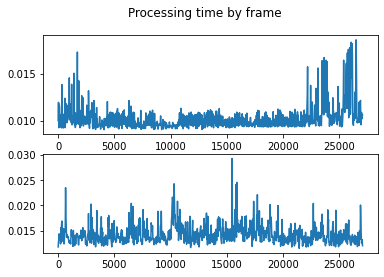

In [29]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Processing time by frame')
ax1.plot(results_tsn[0], results_tsn[1])
ax2.plot(results_tsm[0], results_tsm[1])

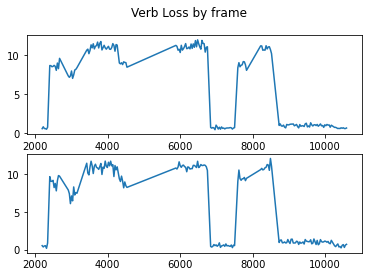

In [30]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Verb Loss by frame')
ax1.plot(labelled_results_tsn[0], labelled_results_tsn[6])
ax2.plot(labelled_results_tsm[0], labelled_results_tsm[6])

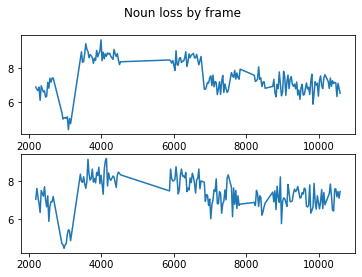

In [31]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Noun loss by frame')
ax1.plot(labelled_results_tsn[0], labelled_results_tsn[7])
ax2.plot(labelled_results_tsm[0], labelled_results_tsm[7])